<a href="https://colab.research.google.com/github/msbeigi/sale-analysis/blob/main/backery_sale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirment

In [ ]:
!sudo pip install xgboost
!pip install catboost


In [4]:
import pandas as pd
import numpy as np
from IPython.display import display,HTML
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import time
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import holidays
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestRegressor
# from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import plotly.graph_objects as go


## Initiation and Data Understanding

### Load Data

In [5]:
weather=pd.read_csv("/content/drive/MyDrive/ML/Hand-on/Backery/weather_2021.01.01-2022.10.31.csv")
backery=pd.read_csv("/content/drive/MyDrive/ML/Hand-on/Backery/bakery_sales_2021-2022.csv")
title='<h3>Sample content of Datsets:</h3>'
display(HTML(title))
title='<h3>bakery_sales_2021-2022.csv</h3>'
display(HTML(title))
display(backery.head(7))
title='<h3>weather_2021.01.01-2022.10.31.csv</h3>'
display(HTML(title))
display(weather.head(7))

,Unnamed: 0,date,time,ticket_number,Article,Quantity,UNIT_PRICE
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"
5,11,2021-01-02,09:25,150043.0,BAGUETTE,2.0,"0,90 €"
6,12,2021-01-02,09:25,150043.0,CROISSANT,3.0,"1,10 €"


,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2021-01-01,2.7,1.5,5.7,15.2,NaN,335.0,15.5,31.0,1008.6,NaN
1,2021-01-02,1.3,0.5,2.7,0.8,NaN,336.0,24.7,44.0,1010.1,NaN
2,2021-01-03,0.7,-0.3,1.6,0.0,NaN,327.0,17.1,38.9,1012.1,NaN
3,2021-01-04,0.0,-1.0,1.1,0.0,NaN,329.0,10.6,30.0,1011.4,NaN
4,2021-01-05,0.8,-0.9,2.1,0.0,NaN,338.0,6.2,30.0,1012.1,NaN
5,2021-01-06,0.8,0.2,1.4,0.0,NaN,324.0,8.0,21.0,1015.4,NaN
6,2021-01-07,0.2,-1.6,2.5,0.0,NaN,343.0,6.2,24.0,1017.1,NaN


### Summary Missing Values and Feature Types

In [6]:
meta_backery=['row index' 	,'date of sale ','time of sale ', 'receipt number ','product name ', 'quantity of the product','unit price of the product']
meta_weahter=['The date of the measurement', 'The average air temperature in °C', 'The minimum air temperature in °C','The maximum air temperature in °C'
              ,'The daily precipitation total in mm', 'The snow depth in mm', 'The average wind direction in degrees (°)', 'The average wind speed in km/h'
              ,'The peak wind gust in km/h', 'The average sea-level air pressure in hPa', 'The daily sunshine total in minutes (m)']


missing_values=backery.isna().sum()
missing_values_weather=weather.isna().sum()

feature_typ=backery.dtypes
feature_typ_weather=weather.dtypes

# out put for backery dataset
_=zip(missing_values.index,meta_backery,missing_values.values,feature_typ.values)
df_backer_desc = pd.DataFrame(_, columns=['column','feature_escription', 'number_of_missing_values', 'feature_type']).style.set_properties(**{'text-align': 'left'})
title = "<h3>Backery Dataset Summary with Missing Values and Data Types</h3>"
display(HTML(title))
display(df_backer_desc)
# output for weather dataset
_=zip(missing_values_weather.index,meta_weahter,missing_values_weather.values,feature_typ_weather.values)
df_weather_desc = pd.DataFrame(_, columns=['column','feature_description', 'number_of_missing_values', 'feature_type']).style.set_properties(**{'text-align': 'left'})
title = "<h3>Weather Dataset Summary with Missing Values and Data Types</h3>"
display(HTML(title))
display(df_weather_desc)


,column,feature_escription,number_of_missing_values,feature_type
0,Unnamed: 0,row index,0,int64
1,date,date of sale,0,object
2,time,time of sale,0,object
3,ticket_number,receipt number,0,float64
4,Article,product name,0,object
5,Quantity,quantity of the product,0,float64
6,UNIT_PRICE,unit price of the product,0,object


,column,feature_description,number_of_missing_values,feature_type
0,date,The date of the measurement,0,object
1,tavg,The average air temperature in °C,0,float64
2,tmin,The minimum air temperature in °C,0,float64
3,tmax,The maximum air temperature in °C,0,float64
4,prcp,The daily precipitation total in mm,0,float64
5,snow,The snow depth in mm,654,float64
6,wdir,The average wind direction in degrees (°),2,float64
7,wspd,The average wind speed in km/h,2,float64
8,wpgt,The peak wind gust in km/h,14,float64
9,pres,The average sea-level air pressure in hPa,2,float64


### Statistical Review

In [7]:
title='<h3>Statistical review</h3>'
display(HTML(title))
title='<h4>backery:</h4>'
display(HTML(title))
display(backery.describe())
title='<h4>weather:</h4>'
display(HTML(title))
display(weather.describe())


,Unnamed: 0,ticket_number,Quantity
count,234005.000000,234005.000000,234005.000000
mean,255205.035854,219201.258738,1.538377
std,147501.625992,40053.223896,1.289603
min,0.000000,150040.000000,-200.000000
25%,127979.000000,184754.000000,1.000000
50%,254573.000000,218807.000000,1.000000
75%,382911.000000,253927.000000,2.000000
max,511395.000000,288913.000000,200.000000


,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
count,669.000000,669.000000,669.000000,669.000000,15.000000,667.000000,667.000000,655.000000,667.000000,0.0
mean,13.900747,9.552167,18.830344,2.272945,14.733333,225.757121,12.674813,39.014198,1018.422789,NaN
std,7.710498,6.918623,8.864005,7.402603,9.353889,108.937433,6.022562,14.485416,7.056279,NaN
min,-3.300000,-5.400000,-1.500000,0.000000,10.000000,0.000000,3.100000,11.000000,996.400000,NaN
25%,7.800000,3.800000,12.400000,0.000000,10.000000,155.000000,8.000000,28.000000,1014.200000,NaN
50%,14.200000,9.800000,19.500000,0.000000,10.000000,192.000000,11.300000,37.000000,1018.400000,NaN
75%,20.000000,15.600000,25.500000,0.800000,15.000000,338.500000,16.000000,46.300000,1022.300000,NaN
max,31.800000,24.800000,38.500000,103.400000,41.000000,359.000000,41.000000,93.000000,1039.300000,NaN


## Data preparation

### Missing Values

In [8]:
def drop_nonvalue(df :pd.DataFrame)->pd.DataFrame:
  """
  Args:
    df: weather dataset as dataframe input
  Returns:
    returns cleared dataframe of missing values
  """
  df.drop(['tsun','snow'], axis=1,inplace=True)

  return df

def impute_missing_values(df:pd.DataFrame)->pd.DataFrame:
    """
    Args:
      df: weather dataset as dataframe input
    Returns:
      return the modified DataFrame
    """
    columns_tobe_fill = ['wdir','wspd','wpgt','pres']
    imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=42)
    df[columns_tobe_fill] = imputer.fit_transform(df[columns_tobe_fill])


    return df

In [9]:
df_weather=weather.copy()
df_weather=drop_nonvalue(df_weather)
df_weather=impute_missing_values(df_weather)
print('Number of missing values:\n----------------')
print(df_weather.isna().sum())


Number of missing values:
----------------
date    0
tavg    0
tmin    0
tmax    0
prcp    0
wdir    0
wspd    0
wpgt    0
pres    0
dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### Anomalies

In [10]:
def drop_nodata_bakey(df: pd.DataFrame)->pd.DataFrame:
  """
  Args:
   df: bakery dataset as dataframe input
  Returns:
    return dataset without anomaly data
  """
  no_data_indice=df[df['Article']=='.'].index
  df.drop(no_data_indice, inplace=True)
  df['Article'] = df['Article'].str.strip()
  return df

def false_quantity(df: pd.DataFrame)-> pd.DataFrame:
  """
  Removes negative quanitities
  Args:
   df: bakery dataset as dataframe input
  Returns:
    return dataset without negative quanitities
  """


  no_data_indice=df[df['Quantity']<=0].index
  df.drop(no_data_indice, inplace=True,axis=0)

  return df

def false_price(df: pd.DataFrame)-> pd.DataFrame:
  """
  Removes zero unit price
  Args:
   df: bakery dataset as dataframe input
  Returns:
    return dataset without zero unit price
  """

  no_data_indice=df[df['UNIT_PRICE']=='0,00 €'].index
  df.drop(no_data_indice, inplace=True,axis=0)

  return df


## Feature Engineering

In [11]:
def encode_bakery(df: pd.DataFrame)->pd.DataFrame:
  """
  Args:
   df: bakery dataset as dataframe input
  Returns:
    return dataset with encoded Article feature
  """
  label_encoder = LabelEncoder()
  df['Article_Label'] = label_encoder.fit_transform(df['Article'])
  return df


def onehot_encode_bakery(df: pd.DataFrame)  ->pd.DataFrame:
  """
  Args:
   df: bakery dataset as dataframe input
  Returns:
    return dataset with encoded Article feature in oneHot
  """
  encoder = OneHotEncoder(sparse=False)
  article_encoded = encoder.fit_transform(df[['Article']])
  encode_columns=encoder.get_feature_names_out()
  encoded_df=pd.DataFrame(article_encoded,columns=encode_columns)
  df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)
  return df

def added_feature_bakery(df: pd.DataFrame)-> pd.DataFrame:
  """
  Args:
   df: bakery dataset as dataframe input
  Returns:
    return new dataset with added feature
  """

  df=df.rename(columns={'Unnamed: 0':'index'})

  df['unit_price_value']= df['UNIT_PRICE'].apply(lambda x: extract_price(x))
  # df["total_sale_item"]= df['Quantity']*df['unit_price_value']
  df=df.rename(columns={'Unnamed: 0':'index'})

  return df

def added_feature_weather(df: pd.DataFrame)-> pd.DataFrame:
  """
  Args:
   df: weather dataset as dataframe input
  Returns:
    return new dataset with added feature
  """
  df['is_rainy']=df['prcp']>0
  df['temp_range'] = df['tmax'] - df['tmin']
  df['is_cold_day'] = (df['tavg'] < 10).astype(int)
  df['is_hot_day'] = (df['tavg'] > 25).astype(int)
  df['is_heavy_wind'] = (df['wspd'] > 20).astype(int)
  df['is_high_pressure'] = (df['pres'] > 1015).astype(int)
  df['date'] = df['date'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d'))

  df['day_of_week'] = df['date'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d').dayofweek)
  df['day_name']= df['date'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d').day_name())
  df['is_weekend'] = df['day_name'].isin(['Saturday', 'Sunday']).astype(int)


  df['month'] = df['date'].dt.month
  df['week'] = df['date'].dt.isocalendar().week
  df['day'] = df['date'].dt.day

  fr_holidays = holidays.France()
  df['is_holiday'] = df['date'].apply(lambda x: x in fr_holidays)
  return df

def extract_price(price_tag: object)->float:
  """
  Args:
    price_tag: string input for daily sale with currency sign

  Returns:
    returns price value as float
  """
  price_string=str(price_tag)
  price_value=float(price_string[:-2].replace(',','.'))
  return price_value

In [26]:
df_bekery=backery.copy()

df_bekery=drop_nodata_bakey(df_bekery)
df_bekery=encode_bakery(df_bekery)
df_bekery=added_feature_bakery(df_bekery)
df_weather=added_feature_weather(df_weather)


df_bekery=false_price(df_bekery)
df_bekery=false_quantity(df_bekery)


In [28]:
daily_sales = df_bekery.groupby('date',as_index=False) ['Quantity'].sum().reset_index()
daily_sales['date']= pd.to_datetime(daily_sales['date'])
merged_data = pd.merge(daily_sales, df_weather, on='date')
merged_data


,index,date,Quantity,tavg,tmin,tmax,prcp,wdir,wspd,wpgt,...,is_hot_day,is_heavy_wind,is_high_pressure,day_of_week,day_name,is_weekend,month,week,day,is_holiday
0,0,2021-01-02,580.0,1.3,0.5,2.7,0.8,336.0,24.7,44.0,...,0,1,0,5,Saturday,1,1,53,2,False
1,1,2021-01-03,565.0,0.7,-0.3,1.6,0.0,327.0,17.1,38.9,...,0,0,0,6,Sunday,1,1,53,3,False
2,2,2021-01-04,315.0,0.0,-1.0,1.1,0.0,329.0,10.6,30.0,...,0,0,0,0,Monday,0,1,1,4,False
3,3,2021-01-05,312.0,0.8,-0.9,2.1,0.0,338.0,6.2,30.0,...,0,0,0,1,Tuesday,0,1,1,5,False
4,4,2021-01-07,310.0,0.2,-1.6,2.5,0.0,343.0,6.2,24.0,...,0,0,1,3,Thursday,0,1,1,7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,595,2022-09-26,401.0,14.8,11.8,18.3,2.8,297.0,7.8,22.2,...,0,0,0,0,Monday,0,9,39,26,False
596,596,2022-09-27,433.0,13.4,10.7,16.3,3.6,240.0,10.5,33.0,...,0,0,0,1,Tuesday,0,9,39,27,False
597,597,2022-09-28,357.0,14.2,11.2,19.2,4.3,190.0,15.9,48.0,...,0,0,0,2,Wednesday,0,9,39,28,False
598,598,2022-09-29,430.0,12.2,9.3,15.7,24.4,321.0,6.9,18.5,...,0,0,0,3,Thursday,0,9,39,29,False


### Feature importance

#### Features' Pearson correlation

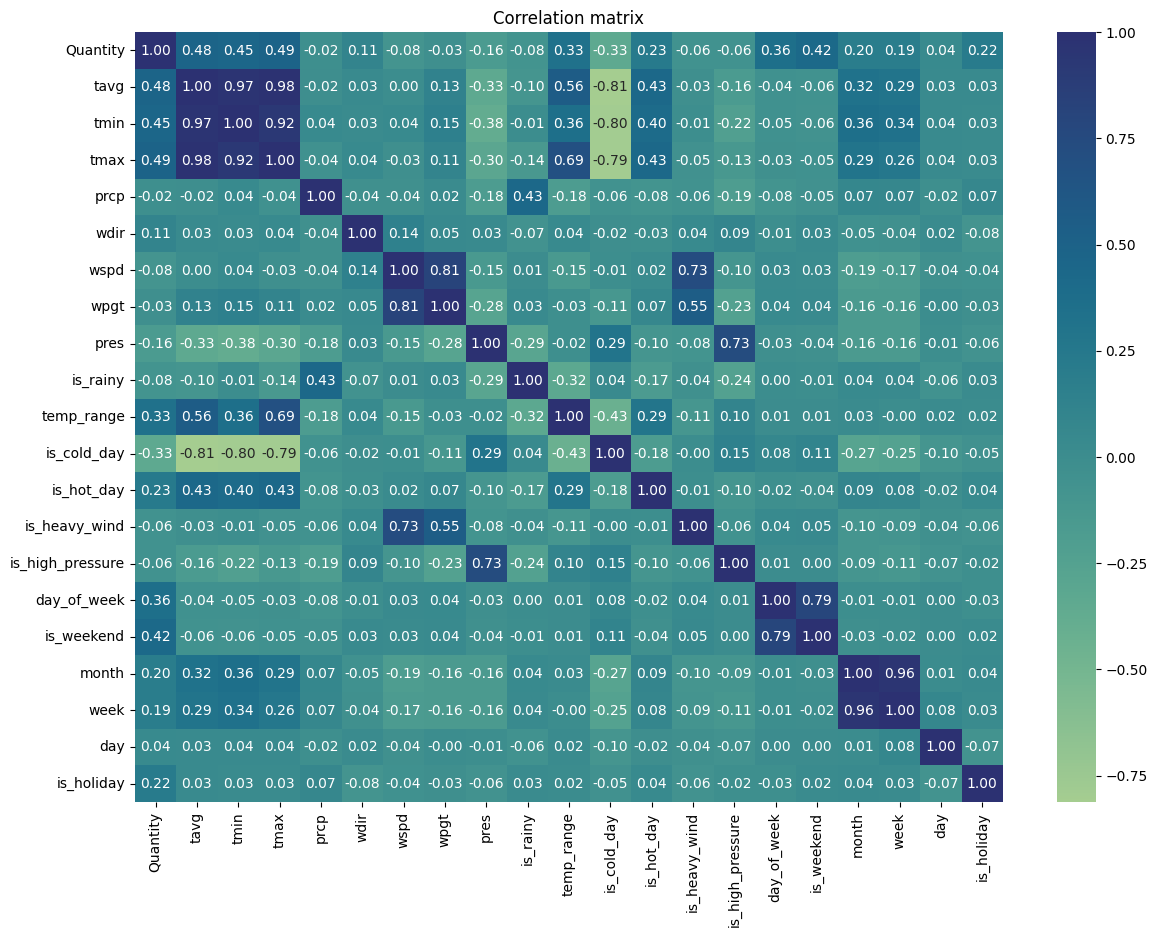

Correlation values with quantity:
Quantity            1.000000
tavg                0.477475
tmin                0.452402
tmax                0.489040
prcp               -0.023332
wdir                0.106712
wspd               -0.084913
wpgt               -0.032368
pres               -0.164204
is_rainy           -0.080994
temp_range          0.334972
is_cold_day        -0.331951
is_hot_day          0.233673
is_heavy_wind      -0.061429
is_high_pressure   -0.056467
day_of_week         0.360633
is_weekend          0.423005
month               0.197357
week                0.194193
day                 0.038358
is_holiday          0.219997
Name: Quantity, dtype: float64


In [29]:


correlation_merge=merged_data[[ 'Quantity', #'total_sale_item', 'Article_Label',
       'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres',
       'is_rainy', 'temp_range', 'is_cold_day', 'is_hot_day', 'is_heavy_wind',
       'is_high_pressure', 'day_of_week', 'is_weekend', 'month',
       'week', 'day', 'is_holiday']].corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_merge, cmap='crest',annot=True, fmt='.2f',)
plt.title('Correlation matrix')
plt.show()
print('Correlation values with quantity:')
print(dict(correlation_merge)['Quantity'])


In [31]:
# correlation_merge[correlation_merge[]]['Quantity']

correl=dict(correlation_merge['Quantity'])
correl_list=[]
for i in correl:
    if(np.abs(correl[i])>0.01 and i!='Quantity'):
        correl_list.append(i)
print(f'Top features:\n{correl_list}')

Top features:
['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres', 'is_rainy', 'temp_range', 'is_cold_day', 'is_hot_day', 'is_heavy_wind', 'is_high_pressure', 'day_of_week', 'is_weekend', 'month', 'week', 'day', 'is_holiday']


In [32]:
df_train=merged_data[correl_list]
df_y=merged_data['Quantity']
X_train,X_test,y_train,y_test=train_test_split(df_train, df_y, test_size=0.3, random_state=42)


#### Feature imporatnce with LightGBMRegressor & ExtraTreesRegressor

In [33]:


etr = ExtraTreesRegressor(n_estimators=300, random_state=42)
etr.fit(X_train, y_train)
feature_importances_etr = etr.feature_importances_

lgbm = lgb.LGBMRegressor(n_estimators=100, max_depth=10, random_state=42)
lgbm.fit(X_train, y_train)

feature_importances_lgbm = lgbm.feature_importances_


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 940
[LightGBM] [Info] Number of data points in the train set: 420, number of used features: 19
[LightGBM] [Info] Start training from score 604.295238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

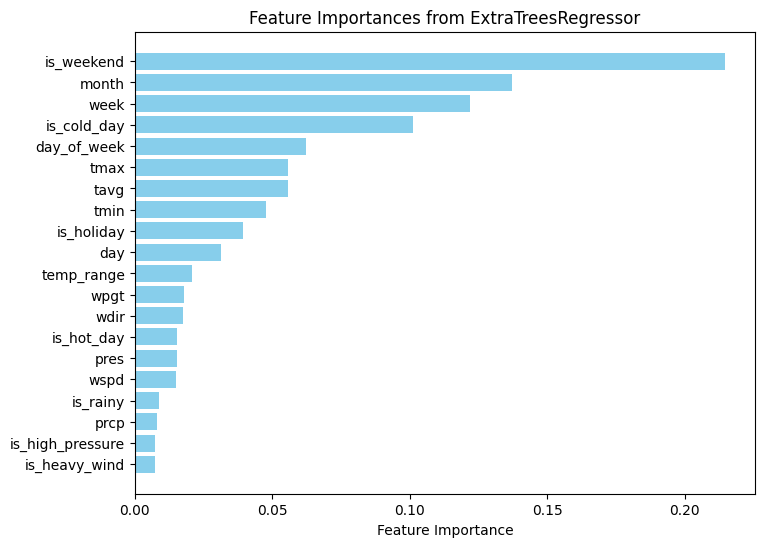


Top features from ExtraTreesRegressor: ['is_weekend' 'month' 'week' 'is_cold_day' 'day_of_week' 'tmax' 'tavg'
 'tmin' 'is_holiday' 'day']


top features from LGBMRegressor:['week' 'tmax' 'pres' 'day' 'day_of_week' 'tmin' 'wspd' 'wdir'
 'temp_range' 'tavg']



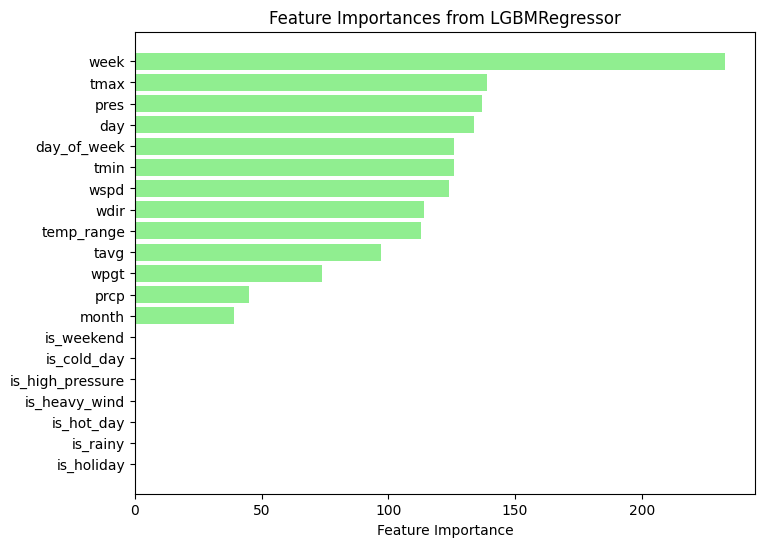

In [34]:
features = X_train.columns
importances = pd.DataFrame({
    'Feature': features,
    'Importance_ETR': feature_importances_etr,
    'Importance_LGBM': feature_importances_lgbm
})

importances_etr = importances.sort_values(by='Importance_ETR', ascending=False)
plt.figure(figsize=(8, 6))
plt.barh(importances_etr['Feature'], importances_etr['Importance_ETR'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances from ExtraTreesRegressor')
plt.gca().invert_yaxis()
plt.show()

# importances = importances.sort_values(by='Importance_LGBM', ascending=False)
top_features_etr = importances_etr[:10]['Feature'].values
print(f'\nTop features from ExtraTreesRegressor: {top_features_etr}\n')

importances_lgbm = importances.sort_values(by='Importance_LGBM', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importances_lgbm['Feature'], importances_lgbm['Importance_LGBM'], color='lightgreen')
plt.xlabel('Feature Importance')
plt.title('Feature Importances from LGBMRegressor')
plt.gca().invert_yaxis()


top_features_lgbm = importances_lgbm[:10]['Feature'].values
print(f'\ntop features from LGBMRegressor:{top_features_lgbm}\n')
plt.show()


In [35]:

selection_list_features=set(correl_list).union(set(top_features_lgbm)).union(set(top_features_etr))
print(selection_list_features)

{'tmax', 'is_holiday', 'month', 'wdir', 'day_of_week', 'is_heavy_wind', 'tmin', 'is_rainy', 'is_weekend', 'is_cold_day', 'pres', 'temp_range', 'is_high_pressure', 'is_hot_day', 'wspd', 'week', 'wpgt', 'day', 'prcp', 'tavg'}


## Modeling

In [36]:
selection_list_features = [feature for feature in selection_list_features if (feature not in ['Article_Label','total_sale_item'])]

df_train=merged_data[selection_list_features]

X_train, X_test, y_train, y_test = train_test_split(df_train, df_y, test_size=0.3, random_state=42)


### CrossValidation on randomforestregressor

In [37]:


param_grid_rf = {'randomforestregressor__n_estimators': [100, 200,300],'randomforestregressor__max_depth': [10, 20]}

pipe_rf = make_pipeline( RandomForestRegressor())
grid_search_rf = GridSearchCV(estimator=pipe_rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error',  n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
print("Best parameters found for RandomForestRegressor: ", best_params_rf)



Best parameters found for RandomForestRegressor:  {'randomforestregressor__max_depth': 10, 'randomforestregressor__n_estimators': 200}


#### RandomForestRegressor

In [38]:
rf_model = RandomForestRegressor(n_estimators=100,max_depth= 10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

final_y_pred_rf=np.round(y_pred).astype(int)
print(f'Final Mean Absolute Error Final Prediction: {mean_absolute_error(y_test, final_y_pred_rf)}')

Mean Absolute Error: 97.14860996313772
Final Mean Absolute Error Final Prediction: 97.16666666666667


,true,prediction,Final prediction
0,428.0,414.523087,415
1,249.0,444.696031,445
2,714.0,893.007686,893
3,520.0,458.952423,459
4,928.0,882.232825,882
...,...,...,...
175,726.0,570.182199,570
176,406.0,442.857889,443
177,585.0,483.718164,484
178,446.0,448.152759,448


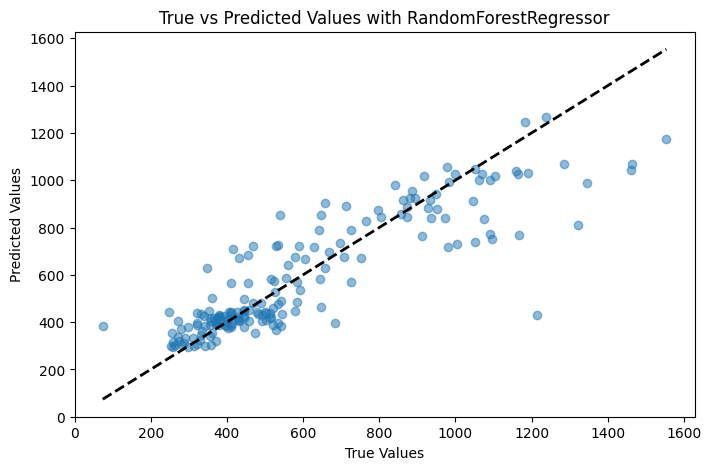

In [23]:
result_predict=zip(y_test,y_pred,final_y_pred_rf)
df_result_rf=pd.DataFrame(result_predict, columns=['true','prediction','Final prediction'])
display(df_result_rf)

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values with RandomForestRegressor')
plt.show()

### Prediction with CatBoost

In [259]:
cat= CatBoostRegressor(iterations=2000,
    learning_rate=0.001, #eval_metric='RMSE',
    depth=6,
    l2_leaf_reg=2,
    random_strength=5,
    bagging_temperature=0.2,
    border_count=256,
    eval_metric='RMSE')

pipe_cat=make_pipeline(StandardScaler(),cat)
pipe_cat.fit(X_train, y_train)
y_pred_cat=pipe_cat.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_cat)
print(f'Mean Absolute Error: {mae}')

final_y_pred_cat=np.round(y_pred_cat).astype(int)
print(f'Mean Absolute Error Final Prediction: {mean_absolute_error(y_test, final_y_pred_cat)}')

0:	learn: 319.7603354	total: 14.1ms	remaining: 28.1s
1:	learn: 319.6220025	total: 17.7ms	remaining: 17.7s
2:	learn: 319.4895410	total: 24.5ms	remaining: 16.3s
3:	learn: 319.3982849	total: 28.5ms	remaining: 14.2s
4:	learn: 319.2983806	total: 36.2ms	remaining: 14.4s
5:	learn: 319.1658543	total: 42.4ms	remaining: 14.1s
6:	learn: 319.0291229	total: 47.7ms	remaining: 13.6s
7:	learn: 318.8952585	total: 52.7ms	remaining: 13.1s
8:	learn: 318.7604617	total: 57.1ms	remaining: 12.6s
9:	learn: 318.6270864	total: 61.8ms	remaining: 12.3s
10:	learn: 318.4980106	total: 66.5ms	remaining: 12s
11:	learn: 318.3789895	total: 70.1ms	remaining: 11.6s
12:	learn: 318.2730643	total: 79.9ms	remaining: 12.2s
13:	learn: 318.1712018	total: 90.5ms	remaining: 12.8s
14:	learn: 318.0392489	total: 98.1ms	remaining: 13s
15:	learn: 317.8963901	total: 105ms	remaining: 13s
16:	learn: 317.8238718	total: 106ms	remaining: 12.3s
17:	learn: 317.7641233	total: 110ms	remaining: 12.1s
18:	learn: 317.6182177	total: 115ms	remaining: 

In [260]:
gb_model=GradientBoostingRegressor(n_estimators=300, learning_rate=0.01, max_depth=6,
                                   max_features='sqrt', min_samples_leaf=5, min_samples_split=2, loss='huber', random_state =10)

pipe_gb=make_pipeline(StandardScaler(),cat)
pipe_gb.fit(X_train, y_train)
y_pred_gb=pipe_gb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_gb)
print(f'Mean Absolute Error: {mae}')

final_y_pred_gb=np.round(y_pred_gb).astype(int)
print(f'Mean Absolute Error: {mean_absolute_error(y_test, final_y_pred_gb)}')


0:	learn: 319.7603354	total: 12ms	remaining: 23.9s
1:	learn: 319.6220025	total: 14.5ms	remaining: 14.5s
2:	learn: 319.4895410	total: 16.8ms	remaining: 11.2s
3:	learn: 319.3982849	total: 19ms	remaining: 9.46s
4:	learn: 319.2983806	total: 21.1ms	remaining: 8.42s
5:	learn: 319.1658543	total: 23.5ms	remaining: 7.82s
6:	learn: 319.0291229	total: 25.7ms	remaining: 7.32s
7:	learn: 318.8952585	total: 27.9ms	remaining: 6.95s
8:	learn: 318.7604617	total: 31.1ms	remaining: 6.88s
9:	learn: 318.6270864	total: 35ms	remaining: 6.97s
10:	learn: 318.4980106	total: 37.2ms	remaining: 6.72s
11:	learn: 318.3789895	total: 39.5ms	remaining: 6.54s
12:	learn: 318.2730643	total: 41.7ms	remaining: 6.37s
13:	learn: 318.1712018	total: 43.8ms	remaining: 6.21s
14:	learn: 318.0392489	total: 45.9ms	remaining: 6.08s
15:	learn: 317.8963901	total: 48.1ms	remaining: 5.97s
16:	learn: 317.8238718	total: 48.8ms	remaining: 5.69s
17:	learn: 317.7641233	total: 50.9ms	remaining: 5.61s
18:	learn: 317.6182177	total: 53.1ms	remaini

### Test data Forcasting

In [333]:
X_test_=df_weather[df_weather['date']>='2022-09-30'][selection_list_features]


In [341]:
y_pred_ = rf_model.predict(X_test)

final_y_pred_=np.round(y_pred_).astype(int)
df_result=pd.DataFrame(final_y_pred_,columns=['Prediction'])
df_result.reset_index(drop=True, inplace=True)
df_result.to_csv('prediction-result.csv', index=False)
df_result

,Prediction
0,423
1,442
2,898
3,464
4,888
...,...
175,580
176,430
177,488
178,452


## EDA

### Best Sellers

Top Selling Items:
                  Article        index  ticket_number  Quantity  \
138  TRADITIONAL BAGUETTE  17484243637   1.484361e+10  118093.0   
30              CROISSANT   2989010778   2.527759e+09   29822.0   
83       PAIN AU CHOCOLAT   2746027770   2.323578e+09   25367.0   
29                  COUPE   5132096047   4.449497e+09   23601.0   
5                 BANETTE   3810010248   3.286079e+09   22870.0   
2                BAGUETTE   3823527983   3.320439e+09   22156.0   
23        CEREAL BAGUETTE   1170784478   1.057516e+09    7478.0   
124         SPECIAL BREAD   1294655065   1.125667e+09    5488.0   
55       FORMULE SANDWICH   1045896336   9.017509e+08    5285.0   
133            TARTELETTE    712834265   6.198813e+08    5051.0   

     Article_Label  unit_price_value  
138        9361511          82980.75  
30          354888          12962.45  
83          884184          12971.90  
29          611580           3057.90  
5            90120          16224.45  
2        

<ipython-input-41-68cb09379f95>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Quantity', y='Article', data=top_sellers, palette='viridis')


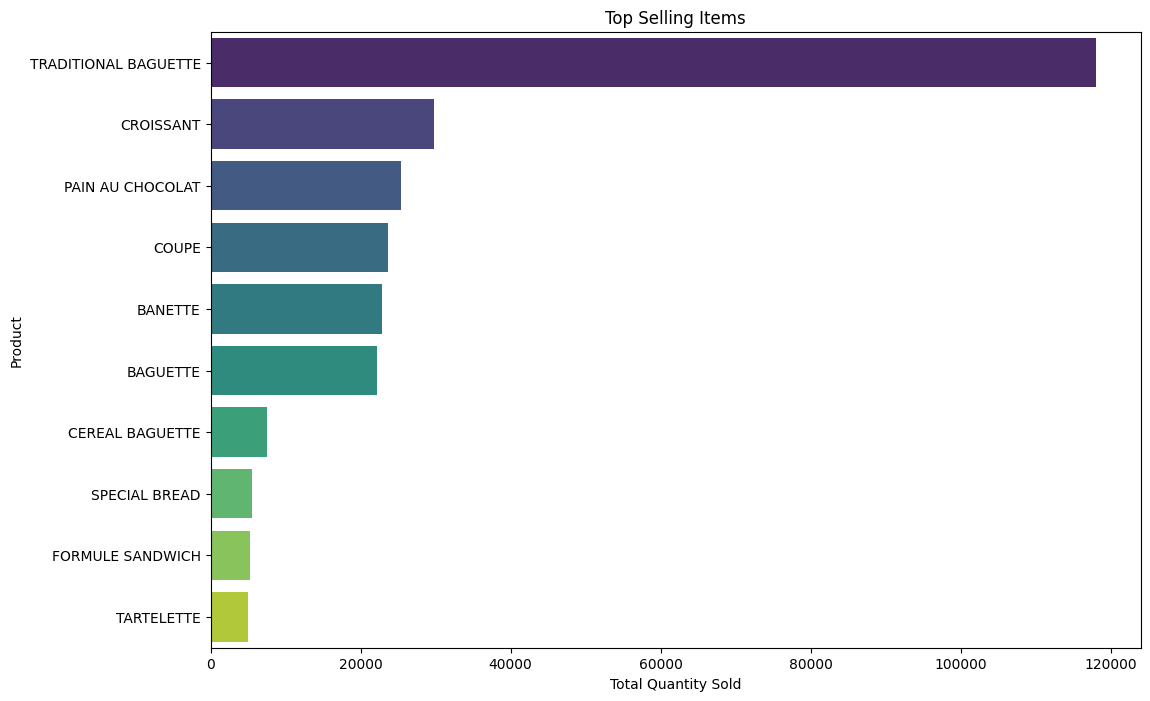

In [41]:


item_sales = df_bekery.groupby(['Article']).sum(['Quantity']).reset_index()

top_sellers = item_sales.sort_values(by='Quantity', ascending=False).head(10)

print("Top Selling Items:")
print(top_sellers)

plt.figure(figsize=(12, 8))
sns.barplot(x='Quantity', y='Article', data=top_sellers, palette='viridis')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product')
plt.title('Top Selling Items')
plt.show()

### Daily Sale vs Weekend, Holidays, Rainy day

<ipython-input-116-379b2cf051a6>:45: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



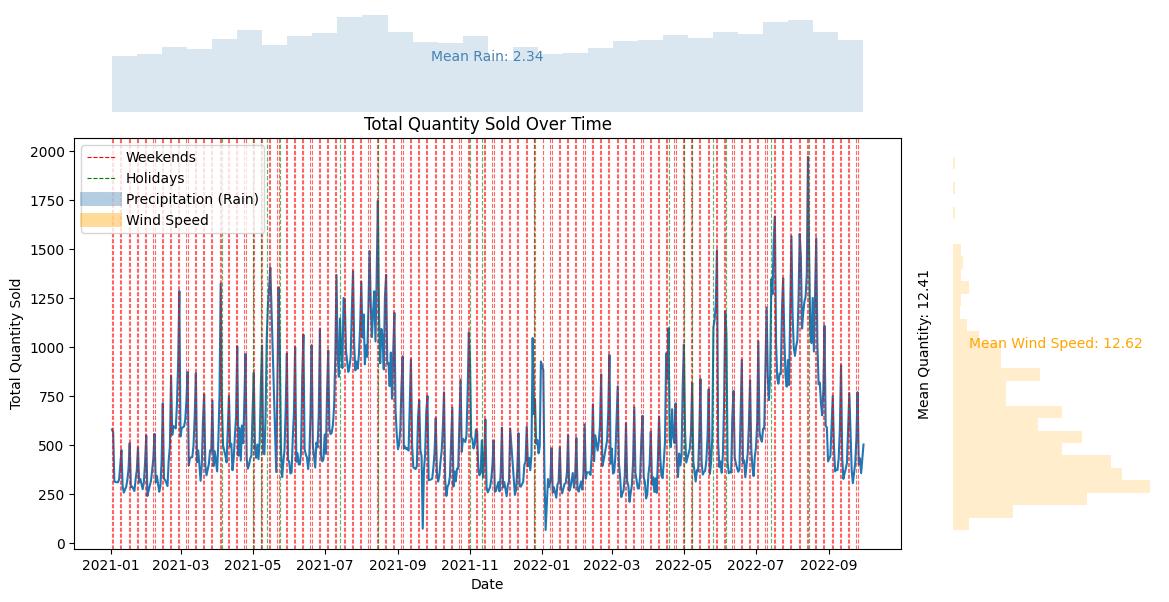

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D

fig, ax = plt.subplots(2, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [4, 1], 'height_ratios': [1, 4], 'hspace': 0.1, 'wspace': 0.1})


ax[1, 0].plot(merged_data.groupby('date')['Quantity'].sum(), label='Total Quantity Sold')
ax[1, 0].set_xlabel('Date')
ax[1, 0].set_ylabel('Total Quantity Sold')
ax[1, 0].set_title('Total Quantity Sold Over Time')
weekends = merged_data[merged_data['is_weekend'] == 1]['date'].unique()
for weekend in weekends:
    ax[1, 0].axvline(x=weekend, color='red', linestyle='--', alpha=0.6, linewidth=0.8)

holidays = merged_data[merged_data['is_holiday'] == 1]['date'].unique()
for holiday in holidays:
    ax[1, 0].axvline(x=holiday, color='green', linestyle='--', alpha=0.6, linewidth=0.85)

ax[0, 0].hist(merged_data['date'][merged_data['prcp'].notnull()], bins=30, alpha=0.2, color='steelblue')
ax[0, 0].axis('off')

ax[1, 1].hist(merged_data['wspd'][merged_data['wspd'].notnull()], bins=30, orientation='horizontal', alpha=0.2, color='orange')
ax[1, 1].axis('off')

ax[0, 1].axis('off')

legend = [
    Line2D([0], [0], color='red', linestyle='--', linewidth=0.8, label='Weekends'),
    Line2D([0], [0], color='green', linestyle='--', linewidth=0.8, label='Holidays'),
    Line2D([0], [0], color='steelblue', alpha=0.4, linewidth=10, label='Precipitation (Rain)'),
    Line2D([0], [0], color='orange', alpha=0.4, linewidth=10, label='Wind Speed')
]
ax[1, 0].legend(handles=legend)

mean_rain = merged_data['prcp'].mean()
mean_wind_speed = merged_data['wspd'].mean()
mean_quantity = merged_data['Quantity'].mean()
ax[0, 0].annotate(f'Mean Rain: {mean_rain:.2f}', xy=(0.5, 0.5), xycoords='axes fraction', ha='center', fontsize=10, color='steelblue')
ax[1, 1].annotate(f'Mean Wind Speed: {mean_wind_speed:.2f}', xy=(0.5, 0.5), xycoords='axes fraction', va='center', ha='center', fontsize=10, color='orange')
ax[1, 0].annotate(f'Mean Quantity: {mean_quantity:.2f}', xy=(1.02, 0.5), xycoords='axes fraction', va='center', fontsize=10, color='black', rotation=90)


plt.tight_layout()
plt.show()


####High Sale days

In [117]:
peak_sale_date_list=merged_data.groupby('date')['Quantity'].sum().sort_values(ascending=False)[0:10]

for c,i in enumerate(peak_sale_date_list.index):
  print(f"{c+1} Highest Sales Day: {i.strftime('%Y-%m-%d')}, Quantity Sold:{peak_sale_date_list[i]}")
  is_holiday=merged_data[merged_data['date']==i.strftime('%Y-%m-%d')]['is_holiday'].values[0]
  is_weekend=merged_data[merged_data['date']==i.strftime('%Y-%m-%d')]['is_weekend'].values[0]
  day_name=merged_data[merged_data['date']==i.strftime('%Y-%m-%d')]['day_name'].values[0]

  high_sale_min_temprature=weather[weather['date']==i.strftime('%Y-%m-%d')]['prcp'].values[0]
  high_sale_max_temprature=weather[weather['date']==i.strftime('%Y-%m-%d')]['tmax'].values[0]
  high_sale_min_temprature=weather[weather['date']==i.strftime('%Y-%m-%d')]['tmin'].values[0]

  high_sale_rain_amount=weather[weather['date']==i.strftime('%Y-%m-%d')]['prcp'].values[0]
  high_sale_wind_speed=weather[weather['date']==i.strftime('%Y-%m-%d')]['wspd'].values[0]
  print(f'Highest Sales Day Rain amount: {high_sale_rain_amount}, wind speed:{high_sale_wind_speed}')
  print(f'Highest Temperature:{high_sale_max_temprature}, minimum temperature{high_sale_min_temprature}')
  print(f'Holiday: {is_holiday}, day name:{day_name}\n')

1 Highest Sales Day: 2022-08-14, Quantity Sold:1970.0
Highest Sales Day Rain amount: 7.6, wind speed:12.4
Highest Temperature:31.6, minimum temperature18.2
Holiday: False, day name:Sunday

2 Highest Sales Day: 2021-08-15, Quantity Sold:1745.0
Highest Sales Day Rain amount: 0.0, wind speed:9.5
Highest Temperature:34.1, minimum temperature21.8
Holiday: True, day name:Sunday

3 Highest Sales Day: 2022-07-17, Quantity Sold:1664.0
Highest Sales Day Rain amount: 0.0, wind speed:10.3
Highest Temperature:31.5, minimum temperature16.7
Holiday: False, day name:Sunday

4 Highest Sales Day: 2022-08-07, Quantity Sold:1576.0
Highest Sales Day Rain amount: 0.0, wind speed:13.5
Highest Temperature:30.1, minimum temperature17.2
Holiday: False, day name:Sunday

5 Highest Sales Day: 2022-07-31, Quantity Sold:1565.0
Highest Sales Day Rain amount: 0.0, wind speed:11.0
Highest Temperature:32.6, minimum temperature18.0
Holiday: False, day name:Sunday

6 Highest Sales Day: 2022-08-21, Quantity Sold:1554.0
Hig

#### Least sale days

In [118]:
peak_sale_date_list=merged_data.groupby('date')['Quantity'].sum().sort_values(ascending=True)[0:10]

for c,i in enumerate(peak_sale_date_list.index):
  print(f"{c+1} Lowest Sales Day: {i.strftime('%Y-%m-%d')}, Quantity Sold:{peak_sale_date_list[i]}")
  is_holiday=merged_data[merged_data['date']==i.strftime('%Y-%m-%d')]['is_holiday'].values[0]
  is_weekend=merged_data[merged_data['date']==i.strftime('%Y-%m-%d')]['is_weekend'].values[0]
  day_name=merged_data[merged_data['date']==i.strftime('%Y-%m-%d')]['day_name'].values[0]

  high_sale_min_temprature=weather[weather['date']==i.strftime('%Y-%m-%d')]['prcp'].values[0]
  high_sale_max_temprature=weather[weather['date']==i.strftime('%Y-%m-%d')]['tmax'].values[0]
  high_sale_min_temprature=weather[weather['date']==i.strftime('%Y-%m-%d')]['tmin'].values[0]

  high_sale_rain_amount=weather[weather['date']==i.strftime('%Y-%m-%d')]['prcp'].values[0]
  high_sale_wind_speed=weather[weather['date']==i.strftime('%Y-%m-%d')]['wspd'].values[0]
  print(f'Lowest Sales Day Rain amount: {high_sale_rain_amount}, wind speed:{high_sale_wind_speed}')
  print(f'Highest Temperature:{high_sale_max_temprature}, minimum temperature{high_sale_min_temprature}')
  print(f'Holiday: {is_holiday}, day name:{day_name}\n')

1 Lowest Sales Day: 2022-01-04, Quantity Sold:67.0
Lowest Sales Day Rain amount: 0.3, wind speed:31.3
Highest Temperature:13.3, minimum temperature7.8
Holiday: False, day name:Tuesday

2 Lowest Sales Day: 2021-09-22, Quantity Sold:74.0
Lowest Sales Day Rain amount: 0.0, wind speed:7.8
Highest Temperature:19.0, minimum temperature11.0
Holiday: False, day name:Wednesday

3 Lowest Sales Day: 2022-03-16, Quantity Sold:211.0
Lowest Sales Day Rain amount: 0.0, wind speed:17.5
Highest Temperature:17.8, minimum temperature9.2
Holiday: False, day name:Wednesday

4 Lowest Sales Day: 2022-03-30, Quantity Sold:228.0
Lowest Sales Day Rain amount: 0.3, wind speed:12.1
Highest Temperature:17.0, minimum temperature9.4
Holiday: False, day name:Wednesday

5 Lowest Sales Day: 2022-01-13, Quantity Sold:232.0
Lowest Sales Day Rain amount: 0.0, wind speed:5.0
Highest Temperature:1.5, minimum temperature-2.6
Holiday: False, day name:Thursday

6 Lowest Sales Day: 2022-03-09, Quantity Sold:235.0
Lowest Sales D

### Quantity sold vs day of the week


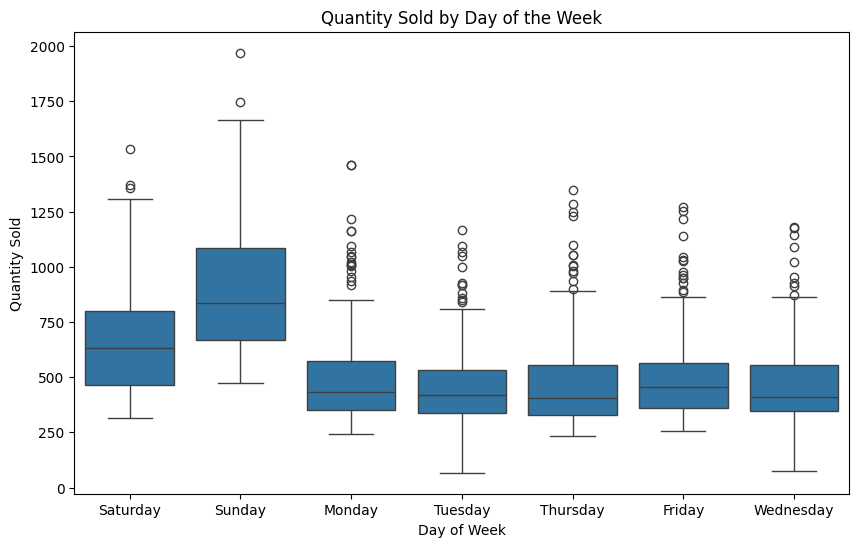

,count,mean,std,min,25%,50%,75%,max
day_name,,,,,,,,
Friday,91.0,532.241758,251.116146,257.0,361.5,455.0,564.50,1269.0
Monday,88.0,545.545455,295.663637,241.0,349.0,432.5,574.25,1463.0
Saturday,90.0,691.555556,293.654582,313.0,464.5,632.0,801.00,1535.0
Sunday,91.0,919.714286,333.135417,475.0,670.5,837.0,1083.00,1970.0
Thursday,89.0,507.943820,274.225536,232.0,329.0,404.0,554.00,1346.0
Tuesday,89.0,480.887640,224.200876,67.0,337.0,417.0,533.00,1166.0
Wednesday,62.0,512.483871,265.371051,74.0,346.0,409.5,556.25,1181.0


In [46]:
total_sale_all_items=merged_data.groupby(['date'], as_index=False).sum()[['date','Quantity']]

total_sale_all_items['day_of_week'] = total_sale_all_items['date'].dt.dayofweek
total_sale_all_items['day_name']=total_sale_all_items['date'].dt.day_name()
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_name', y='Quantity', data=total_sale_all_items)
plt.xlabel('Day of Week')
plt.ylabel('Quantity Sold')
plt.title('Quantity Sold by Day of the Week')
plt.show()
stats_by_day = merged_data.groupby('day_name')['Quantity'].describe()
display(stats_by_day)

## Limitation


1.   'tsun' has no data
2.   'snow' feature only has 15 rows of data
3.   'date' has gap in between



In [138]:
def find_missing_dates(df:pd.DataFrame)->pd.DataFrame:
  """
  Finds date gaps in the given DataFrame.

  Args:
    dataset of weather or bakery
  Returns:
    returns date gaps
  """
  min_date = merged_data['date'].min()
  max_date = merged_data['date'].max()
  date_range = pd.date_range(start=min_date, end=max_date, freq='D')

  missing_dates = date_range[~date_range.isin(merged_data['date'])]

  return missing_dates

missing_dates = find_missing_dates(backery)
heading='<h3> Limitation in data</h3>'
title='<h4>Following dates are missing in the bakery dataset </h4>'
display(HTML(heading))
display(HTML(title))
print(missing_dates)


DatetimeIndex(['2021-01-06', '2021-01-13', '2021-01-20', '2021-01-27',
               '2021-02-03', '2021-02-10', '2021-02-17', '2021-02-24',
               '2021-03-03', '2021-03-10', '2021-03-17', '2021-03-24',
               '2021-03-31', '2021-04-07', '2021-05-17', '2021-05-18',
               '2021-05-19', '2021-05-20', '2021-11-17', '2021-11-24',
               '2021-12-01', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-15', '2022-01-01', '2022-01-05', '2022-01-12',
               '2022-01-19', '2022-01-26', '2022-02-02', '2022-02-09',
               '2022-02-16', '2022-02-23', '2022-05-04', '2022-09-01',
               '2022-09-19'],
              dtype='datetime64[ns]', freq=None)


In [139]:
len(missing_dates)

37